### Data Load

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
df_click = pd.read_csv('dataset/dataset_click.csv')
del df_click['Unnamed: 0']
df_click.head()

,0,1,2,3
0,22.598724,179.023686,163.249317,1
1,2.973941,179.892002,165.433054,1
2,147.763771,177.033637,165.819879,1
3,167.020688,177.214987,166.358002,1
4,154.102063,177.232321,165.434704,1


In [33]:
df_none = pd.read_csv('dataset/dataset_none.csv')
del df_none['Unnamed: 0']
df_none.head()

,0,1,2,3
0,177.023114,176.338735,166.104406,0
1,177.680023,177.702565,167.582472,0
2,178.238596,177.121924,167.263819,0
3,178.061959,177.010129,167.606877,0
4,178.331293,176.677957,167.512249,0


#### 검지손가락 각 랜드마크 기준 정하기

In [34]:
print('--- click 90도 이하 각도 수 ---')
print('total: ', len(df_click))
print('7번 랜드마크 각도: ', len(df_click[df_click['0'] <= 120])) 
print('6번 랜드마크 각도: ', len(df_click[df_click['1'] <= 120])) 
print('6, 7번 랜드마크 각도: ', len(df_click[(df_click['1'] <= 120) & (df_click['0'] <= 120)])) 

--- click 90도 이하 각도 수 ---
total:  1502
7번 랜드마크 각도:  808
6번 랜드마크 각도:  764
6, 7번 랜드마크 각도:  175


In [35]:
print('--- none 90도 이하 각도 수 ---')
print('total: ', len(df_none))
print('7번 랜드마크 각도: ', len(df_none[df_none['0'] <= 120])) # 90도 이하 데이터만 사용
print('6번 랜드마크 각도: ', len(df_none[df_none['1'] <= 120])) # 90도 이하 데이터만 사용

--- none 90도 이하 각도 수 ---
total:  1306
7번 랜드마크 각도:  0
6번 랜드마크 각도:  0


#### 7번 랜드마크 120도를 기준으로 설정

In [36]:
df_click = df_click[df_click['0'] <= 120]
df_click.head()

,0,1,2,3
0,22.598724,179.023686,163.249317,1
1,2.973941,179.892002,165.433054,1
25,101.145285,172.279699,164.064479,1
27,94.565581,174.935962,164.257273,1
28,34.138636,177.078378,163.886451,1


In [37]:
df_data = pd.concat([df_click, df_none])
df_data.head()

,0,1,2,3
0,22.598724,179.023686,163.249317,1
1,2.973941,179.892002,165.433054,1
25,101.145285,172.279699,164.064479,1
27,94.565581,174.935962,164.257273,1
28,34.138636,177.078378,163.886451,1


In [38]:
df_data.tail()

,0,1,2,3
1301,176.423832,173.997588,171.909546,0
1302,176.408986,174.194977,171.699901,0
1303,176.588753,173.374272,172.118063,0
1304,176.571527,173.746418,172.134432,0
1305,176.515446,173.417380,172.506359,0


In [39]:
df_data_copy = df_data.copy() # 원본데이터 저장

In [63]:
df_data[['3']][:10]

,3
0,1
1,1
25,1
27,1
28,1
29,1
30,1
31,1
32,1
33,1


In [41]:
df_target = df_data[['3']] # y 데이터(0, 1)
df_data = df_data[['0', '1', '2']] # x 데이터

In [46]:
df_target[:10]

,3
0,1
1,1
25,1
27,1
28,1
29,1
30,1
31,1
32,1
33,1


### Test / Train Split

In [47]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_data, df_target, test_size=0.2, random_state=0)

In [48]:
y_train[:20]

,3
818,0
935,1
775,0
822,0
583,0
255,0
293,0
351,1
750,1
838,0


In [49]:
# Apply 'One-hot encoding' on labels

from sklearn import preprocessing

enc = preprocessing.OneHotEncoder(categories='auto')

y_train = enc.fit_transform(y_train).toarray()
y_test = enc.fit_transform(y_test).toarray()

print(y_train.shape)
print(y_test.shape)

(1691, 2)
(423, 2)


In [50]:
y_train[:20] 

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
# 0 -> [1., 0.]
# 1 -> [0., 1.]

In [18]:
# # -> one-hot vector
# from tensorflow.keras import utils
# y_train = utils.to_categorical(x_train) # 0 or 1 -> one-hot vector
# y_test = utils.to_categorical(x_test) # 0 or 1 -> one-hot vector

### Model Fit

In [19]:
import tensorflow as tf

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [20]:
model = models.Sequential()

model.add(layers.Dense(input_dim=3, units=64, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization

# model.add(layers.BatchNormalization()) # Use this line as if needed

model.add(layers.Activation('elu')) # elu, relu / layers.ELU, layers.LeakyReLU

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

# 마지막 hidden layer droup out
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output

In [21]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [22]:
history = model.fit(x_train, y_train, batch_size=200, epochs=100, validation_split=0.3) 

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-11-23 15:58:07.074282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 15:58:07.074726: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


1/6 [====>.........................] - ETA: 1s - loss: 169.9707 - categorical_accuracy: 0.5000WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2957a6040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 51ms/step - loss: 145.8420 - categorical_accuracy: 0.5323 - val_loss: 53.3610 - val_

6/6 [==============================] - 0s 4ms/step - loss: 1.1604 - categorical_accuracy: 0.9914 - val_loss: 74.1664 - val_categorical_accuracy: 0.9646
Epoch 45/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1650 - categorical_accuracy: 0.9923 - val_loss: 56.0893 - val_categorical_accuracy: 0.9685
Epoch 46/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4157 - categorical_accuracy: 0.9907 - val_loss: 34.0656 - val_categorical_accuracy: 0.9724
Epoch 47/100
6/6 [==============================] - 0s 4ms/step - loss: 2.4603 - categorical_accuracy: 0.9860 - val_loss: 38.5552 - val_categorical_accuracy: 0.9764
Epoch 48/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6484 - categorical_accuracy: 0.9914 - val_loss: 47.1125 - val_categorical_accuracy: 0.9646
Epoch 49/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5055 - categorical_accuracy: 0.9935 - val_loss: 37.6211 - val_categorical_accuracy: 0.9724
Epoch 50/100
6/6 [=====

Epoch 94/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4870 - categorical_accuracy: 0.9963 - val_loss: 47.2144 - val_categorical_accuracy: 0.9724
Epoch 95/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0347 - categorical_accuracy: 0.9981 - val_loss: 51.1541 - val_categorical_accuracy: 0.9685
Epoch 96/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3082 - categorical_accuracy: 0.9983 - val_loss: 51.3618 - val_categorical_accuracy: 0.9685
Epoch 97/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1048 - categorical_accuracy: 0.9975 - val_loss: 48.2285 - val_categorical_accuracy: 0.9764
Epoch 98/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1096 - categorical_accuracy: 0.9980 - val_loss: 72.7042 - val_categorical_accuracy: 0.9685
Epoch 99/100
6/6 [==============================] - 0s 4ms/step - loss: 0.8644 - categorical_accuracy: 0.9967 - val_loss: 67.7679 - val_categorical_accuracy: 0.9646
Epoch 100/

In [23]:
result = model.evaluate(x_test, y_test)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

14/14 [==============================] - 0s 561us/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
loss (cross-entropy) : 0.0
test accuracy : 1.0


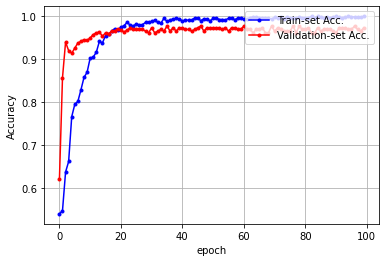

In [24]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 모델 저장

In [27]:
model.save('model/model_juran_ver2.0.h5')

### 새로운 데이터에 대한 예측

In [56]:
model.predict([[120, 170, 170]])

array([[0., 1.]], dtype=float32)

In [61]:
model.predict([[120, 170, 170]])[:1, :1][0]

array([0.], dtype=float32)

In [62]:
if model.predict([[120, 170, 170]])[:1, :1][0] == 0:
    print('none')

none
